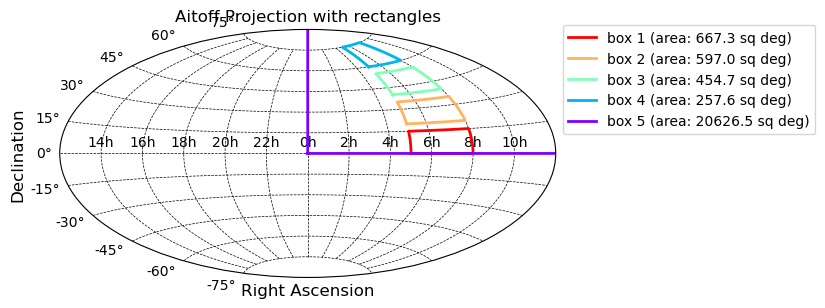

Ratio of number of dots in each box: 
[2.556, 2.53, 1.804, 1.0, 81.248]
Ratio of areas of each box: 
[2.591, 2.318, 1.765, 1.0, 80.08]


In [5]:
def plot_rectangles(boxes, name = 'lat-long rectangles in aitoff-projection.png', radians=False):
    '''Plot rectangles bounded by ra_min, ra_max, dec_min, dec_max, where:
        boxes = [[ra_min1, ra_max1, dec_min1, dec_max1], [ra_min2, ra_max2, dec_min2, dec_max2]]
    
    imports needed packages automatically
    
    Parameters
    -------------
    box : type = list - contains entries for each corner of the lat-long rectangle
                        all coordinates given in degrees
    name (optional, defaults to 'lat-long rectangles in aitoff-projection.png'): type = str - name of .png file

    radians (optional, defaults to False): type = boolean
    Returns
    -------------
    boxes = list of boxes in format [ra_min, ra_max, dec_min, dec_max]
    areas = list of areas of each of the boxes in square degrees.
    Also saves a .png file into working directory
    '''
    
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="aitoff") #TJ set projection format
    if isinstance(boxes[0], int) or isinstance(boxes[0], float):
        #TJ if there is only one box, perform function on the single box
        if radians == False:
            ra_min, ra_max, dec_min, dec_max = np.radians(boxes) #TJ this makes sure ra/dec are in radians
            
        #TJ make a path that circles around the whole box perimeter
        ra_path = [ra_min, ra_max, ra_max, ra_min, ra_min] 
        dec_path = [dec_min, dec_min, dec_max, dec_max, dec_min]
        
        areas = ((ra_max - ra_min)*(np.sin(dec_max) - np.sin(dec_min)))*((180/np.pi)**2) #TJ calculate area for the box
        
        #TJ plot the box in red and label it with its area in square degrees
        ax.plot(ra_path, dec_path, color='red',linestyle = '-', linewidth=2, 
                label = f"custom box (area: {np.round(areas, 1)} sq deg)")
    else: #TJ if the first entry in boxes is a list or array, iterate through each entry as individual boxes
        colors = cm.rainbow(np.linspace(1, 0, len(boxes))) #TJ this is prep for each box to be a different color
        areas = [] #TJ initialize area list
        for i, b in enumerate(boxes): #TJ iterate through each box and do what is described above to each box
            if radians == False:
                ra_min, ra_max = np.radians([b[0], b[1]])
                dec_min, dec_max = np.radians([b[2], b[3]])
            else:
                ra_min, ra_max = [b[0], b[1]]
                dec_min, dec_max = [b[2], b[3]]
            ra_path = [ra_min, ra_max, ra_max, ra_min, ra_min]
            dec_path = [dec_min, dec_min, dec_max, dec_max, dec_min]
            area = ((ra_max - ra_min)*(np.sin(dec_max) - np.sin(dec_min)))*((180/np.pi)**2)
            areas.append(area) #TJ this isnt optimal, but the "boxes" array will never be large, so it should be fine
            ax.plot(ra_path, dec_path, color=colors[i],linestyle='-', linewidth=2, 
                    label = f"box {i+1} (area: {np.round(area, 1)} sq deg)")
    
    xlab = ['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'] #TJ set right ascension tick labels
    ax.set_xticklabels(xlab, weight=300)
    ax.grid(color='black', linestyle='--', linewidth=0.5) #TJ make grid lines pretty thin so box borders show up better
    ax.set_xlabel("Right Ascension", fontsize=12)
    ax.set_ylabel("Declination", fontsize=12)
    ax.set_title("Aitoff Projection with rectangles", fontsize=12)
    ax.legend(bbox_to_anchor=(1, 0.55))
    plt.savefig(name, dpi=300, bbox_inches='tight') #TJ save .png of figure to working directory
    plt.show()
    return areas


def find_ratios(list):
    '''take a list of real numbers, express the list as a ratio to the smallest member of the list
        for example: x = [6, 3, 10, 15]
                     find_ratios(x) will return [2, 1, 3.3, 5]

    Parameters
    -------------
    list : type = list - contains entries that are all real numbers

    Returns
    -------------
    normalized list
    
    '''
    
    n_min = min(list) #TJ find the minimum value in the list to normalize to
    return [x/n_min for x in list] #TJ return the original list, normalized to that smallest area


def evenly_populate_sphere(n_dots):
    '''generates n_dots number of ra and dec values such that they will be evenly distributed over a sphere.

    imports needed packages automatically
    
    Parameters
    -------------
    n_dots : type = int - integer number of dots you want to appear on the sphere
    
    

    Returns
    -------------
    ra : list of right ascension values in radians
    dec : list of declination values in radians
    '''
    
    import numpy as np
    from numpy.random import random
    ra = 2*np.pi*(random(n_dots)) #TJ generates random RA's measured in radians between 0 and 2pi 
    dec = np.arcsin(1.-random(n_dots)*2.) #TJ creates random declinations in radians between +pi/2 and -pi/2
    return ra, dec

def is_it_in(dots, lat_long_box):
    '''determines whether a coordinate (or list of coordinates) is within a given lat-long box
    
    Parameters
    -------------
    dots : type = list - list of ra, dec coordinates in radians, corresponding to dots on a sphere
                
    lat_long_box : type = list - given in the format [ra_min, ra_max, dec_min, dec_max]
    
                    for example, to generate dots inside a lat-long box with ra, dec = [5hr-8hr, 0deg-15deg]: 
                            box = np.radians([(5*15), (8*15), (0), (15)])
                            ra, dec = evenly_populate_sphere(1000)
                            inside = is_it_in([ra,dec], box)
                            dots_in_region = [ra[inside], dec[inside]]

    Returns
    -------------
    boolean value True if coordinate is within box (inclusive of end values on both ends), False if not.
    '''
    
    ii = [((dot[0] >= lat_long_box[0]) & (dot[0] <= lat_long_box[1]) & 
          (dot[1] >= lat_long_box[2]) & (dot[1] <= lat_long_box[3])) for dot in dots]

    return ii #TJ return true or false array corresponding to True if a dot is inside the box

def check_answers(boxes, num_dots=100000, radians=False, name = 'lat-long rectangles in aitoff-projection.png'):
    '''checks that the ratio of the areas is the same as the ratio of the number of dots in each box
    
    imports neeeded packages automatically
    
    Parameters
    -------------
    boxes : type = list - given in the format [[ra_min1, ra_max1, dec_min1, dec_max1],
                                               [ra_min2, ra_max2, dec_min2, dec_max2]]
                        - or as a single box [ra_min, ra_max, dec_min, dec_max]
                                               
    num_dots (optional, defaults to 100,000) : type = int - number of dots, the bigger the number,
                                               the closer the two sets of ratios should be
                
                                               
    name (optional, defaults to 'lat-long rectangles in aitoff-projection.png'): type = str - name of .png file

    
    radians (optional, defaults to False): type = boolean
    
    Returns
    -------------
    Nothing.
    Saves plot in working directory with given (or default) name.png, see "plot_rectangles()" function.
    Prints ratios of areas of each boxes, normalized to the smallest area.
    Prints number of the dots within each box, normalized to smallest number.
    '''
    
    import numpy as np
    if radians == False:
        boxes = np.radians(boxes)
        rad = True
    areas = plot_rectangles(boxes, radians = True)
    normalized_areas = find_ratios(areas)

    #TJ generate random points on a sphere
    ra, dec = evenly_populate_sphere(num_dots)
    all_dots = np.column_stack((ra, dec))  #TJ store as a NumPy array for easier indexing

    #TJ generate list for each box, so all the true values in in_each[0] correspond to dots that are in box1
    in_each = [all_dots[is_it_in(all_dots, box)] for box in boxes]
    
    #TJ count number of points in each box
    num_dots_in_each = [len(each) for each in in_each]  

    #TJ print results, these two list should have every index be fairly close to eachother
    #TJ note: these lists may differ if num_dots is low.
    print(f'Ratio of number of dots in each box: \n{[round(float(r), 3) for r in find_ratios(num_dots_in_each)]}')
    print(f'Ratio of areas of each box: \n{[round(float(r), 3) for r in normalized_areas]}')    
    return None



if __name__ == "__main__":
    #TJ create boxes to verify that the number of dots in each box is proportional to its area

    boxes = [[(5*15), (8*15), (0), (15)], [(5*15), (8*15), (20), (35)], 
             [(5*15), (8*15), (40), (55)], [(5*15), (8*15), (60), (75)],
             [0, 360, 0, 90]] 
    
    check_answers(boxes)